In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np  
from matplotlib import pyplot as plt
from utils import normalize_image,load_dcm_data,plot_coregistration_views,maximum_intensity_projection
from task1_animation import  create_seg_mask
from scipy.ndimage import rotate, zoom, shift
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation

In [2]:
#Load the DCMS, sorted and stacked

dcm_path='RadCTTACEomics_1193-20250418T131346Z-001/RadCTTACEomics_1193/10_AP_Ax2.50mm'
dcms_ref=load_dcm_data(dcm_path)
dcms_ref.sort(key = (lambda x: float(x.SliceLocation)))
pixelarray_ref = np.stack([x.pixel_array for x in dcms_ref], axis=0)
# pixelarray_ref=normalize_image(pixelarray_ref)

dcm_path='RadCTTACEomics_1193-20250418T131346Z-001/RadCTTACEomics_1193/20_PP_Ax2.50mm'
dcms_input =load_dcm_data(dcm_path)
dcms_input .sort(key = (lambda x: float(x.SliceLocation)))
pixelarray_input  = np.stack([x.pixel_array for x in dcms_input ], axis=0)
# pixelarray_input =normalize_image(pixelarray_input )
pixelarray_ref.shape, pixelarray_input .shape

((188, 512, 512), (188, 512, 512))

In [3]:
print("No Acquisition Number available")
any([x.AcquisitionNumber for x in dcms_ref]), any([x.AcquisitionNumber for x in dcms_input ])

No Acquisition Number available


(False, False)

For image coregistration, it is essential that both volumes have matching dimensions. One common solution is to crop the larger volume to match the size of the smaller one.

In [4]:
# Crop the target (reference) to match the moving shape in depth (Z-axis)
depth_input  = pixelarray_input .shape[0]
pixelarray_ref = pixelarray_ref[:depth_input , :, :]
assert pixelarray_ref.shape == pixelarray_input .shape, "Mismatch in shape"

## Initial assesment
The plot below displays a comparison between the target and input DICOM volumes across axial, coronal, and sagittal planes. Each pair of rows corresponds to the same slice index in both volumes. At first glance, the slices appear quite similar. However, upon closer inspection, subtle differences can be observed in the shape of some anatomical structures, and variations in the size of dark regions (e.g., air pockets or fluid) are also noticeable.

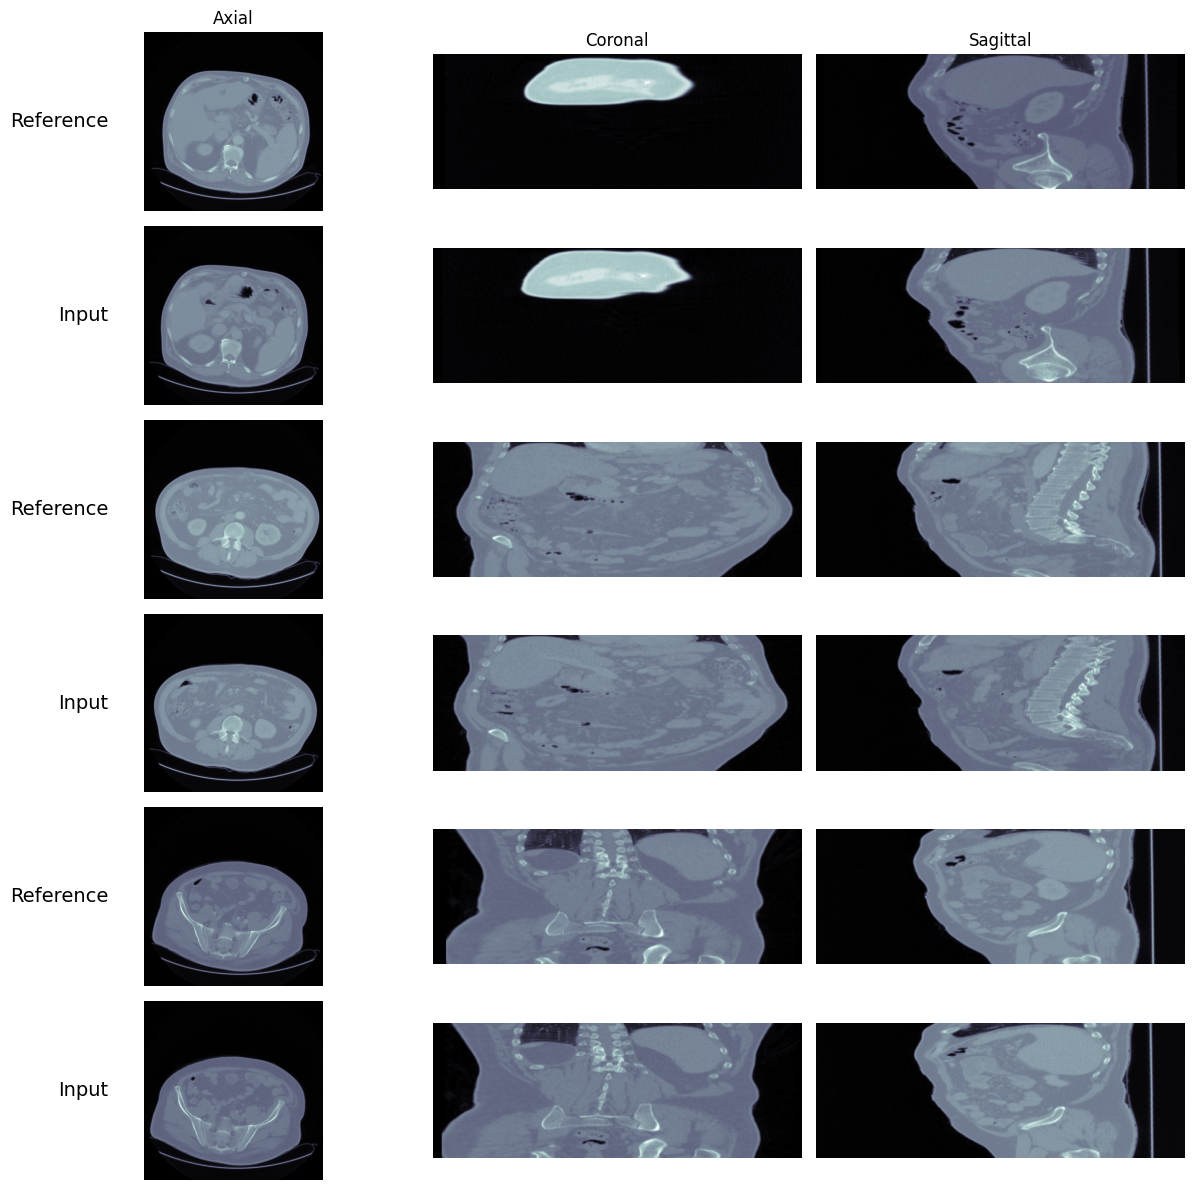

In [5]:
plot_coregistration_views(pixelarray_ref, pixelarray_input )

## Apply Corregistration
In this step, we apply a transformation that includes translation, rotation to align the input volume to the target. To estimate the optimal transformation parameters, we use the least squares optimization method, with the Root Mean Squared Error (RMSE) as the objective (error) function.


### Utils
Frist we start by defining a error function to minimize in which in this case it will be Root mean square deviation. In this case we select RMSE We use RMSE (Root Mean Squared Error) as the loss function because it provides a simple and effective measure of voxel-wise similarity between the fixed and input volumes. It quantifies the average squared difference in intensity values, penalizing larger mismatches more heavily, which helps guide the optimization toward better alignment. Additionally, RMSE is fully differentiable, making it suitable for use in gradient-based optimization methods like least squares.

In [6]:
def mse_loss(fixed, moving):
    """Compute Mean Squared Error (MSE) between two volumes."""
    if fixed.shape != moving.shape:
        raise ValueError("Shape mismatch: fixed and moving volumes must have the same shape.")
    return np.mean((fixed - moving) ** 2)

We also define some util function to apply transformation and to get an initial parameter estimate

In [7]:

def find_volume_centroid(volume: np.ndarray):
    """Compute centroid of non-zero voxels in a 3D volume."""
    nonzero = np.argwhere(volume > 0)
    if nonzero.size == 0:
        raise ValueError("Volume is empty or has no non-zero voxels.")
    return np.mean(nonzero, axis=0)




In [8]:


def rotate_volume_around_axis(volume, angle_deg, axis, order=1):
    """
    Rotates the volume around an arbitrary axis using Rodrigues' rotation.
    """
    from scipy.spatial.transform import Rotation as R

    # Normalize the axis
    axis = np.asarray(axis)
    norm = np.linalg.norm(axis)
    if norm == 0:
        return volume  # no rotation if axis is zero
    axis = axis / norm

    # Create rotation matrix
    r = R.from_rotvec(np.deg2rad(angle_deg) * axis)
    rot_mat = r.as_matrix()

    # Create a coordinate grid
    shape = volume.shape
    coords = np.indices(shape, dtype=np.float32)
    coords = coords.reshape(3, -1)

    # Compute center of volume
    center = np.array(shape)[:, None] / 2

    # Shift to center, rotate, and shift back
    coords_centered = coords - center
    rotated_coords = rot_mat @ coords_centered + center

    # Interpolate values at rotated coordinates
    from scipy.ndimage import map_coordinates
    rotated_volume = map_coordinates(volume, rotated_coords, order=order, mode='nearest').reshape(shape)

    return rotated_volume


def apply_transform(volume, params):
    """Apply translation and rotation around arbitrary axis."""
    params = np.asarray(params)

    # Translation: scaled
    translation = params[:3] 
    transformed = shift(volume, translation, order=1)

    # Rotation around arbitrary axis
    angle = params[3] # degrees
    axis = params[4:7]        # arbitrary axis vector

    transformed = rotate_volume_around_axis(transformed, angle, axis, order=1)

    return transformed


We first calculate the center of volume of the target object to get an initial  estimate on the translation, rotation and scale will be empty at the beging

In [9]:
# pixelarray_input=normalize_image(pixelarray_input)
# pixelarray_ref=normalize_image(pixelarray_ref)

centroid_input  = find_volume_centroid(pixelarray_input )
centroid_ref = find_volume_centroid(pixelarray_ref)
initial_translation = centroid_input  - centroid_ref  # difference between centers
initial_params = np.concatenate([
    initial_translation,              # translation estimate
    [0],                                # rotation angle in degrees
    [ 0, 0, 0   ]                   # no rotation axis (initially set to zero)
])

transformed = apply_transform(pixelarray_input , initial_params)
error_estimation= mse_loss(pixelarray_ref,transformed)

print("Error with initial estimation ", error_estimation)

Error with initial estimation  1784.2391259010801


## Least square Error

In [10]:
error_list=[]
def function_to_minimize(params):
    transformed = apply_transform(pixelarray_input , params)
    # Translation and angle: scaled
    params[:4] /= 10.0
    err=mse_loss(pixelarray_ref, transformed)
    error_list.append(err)
    return err

result = least_squares(
    function_to_minimize,
    x0=initial_params,
    loss='soft_l1',  #It gave us the best results with this constraint
    xtol=1e-12,
    verbose=2
)
result

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7832e+03                                    2.65e+10    
       1              2         1.3781e+03      4.05e+02       6.09e-01       1.48e+09    
       2              3         1.3512e+03      2.69e+01       1.52e-01       3.17e+08    
       3              4         1.3373e+03      1.39e+01       3.80e-02       1.36e+09    
       4             23         1.3373e+03      0.00e+00       0.00e+00       1.36e+09    
`xtol` termination condition is satisfied.
Function evaluations 23, initial cost 1.7832e+03, final cost 1.3373e+03, first-order optimality 1.36e+09.


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.338e+03]
           x: [ 5.697e-04 -5.554e-04  3.216e-05 -6.326e-04  2.732e-01
                2.732e-01  2.732e-01]
        cost: 1337.3410836281178
         jac: [[ 2.768e+04 -2.768e+04  2.768e+04 -2.768e+04  2.768e+04
                 2.768e+04  2.768e+04]]
        grad: [ 1.355e+09 -1.355e+09  1.355e+09 -1.355e+09  1.355e+09
                1.355e+09  1.355e+09]
  optimality: 1355052828.8868573
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00]
        nfev: 23
        njev: 4

In [11]:
final_params=result.x
final_transform = apply_transform(pixelarray_input ,final_params)
final_error= mse_loss(pixelarray_ref,final_transform)
print("Final error ", final_error)
print("Improvement : ", error_estimation-final_error)

Final error  1358.532559131054
Improvement :  425.70656677002603


Text(0, 0.5, 'Error')

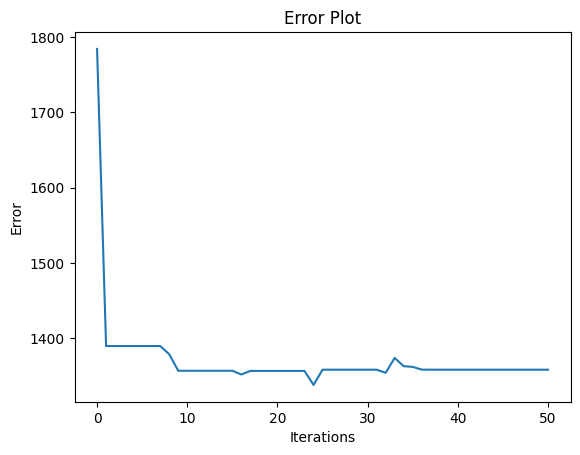

In [12]:
plt.plot(error_list)
plt.title("Error Plot")
plt.xlabel("Iterations")
plt.ylabel("Error")

## Mask and assessment

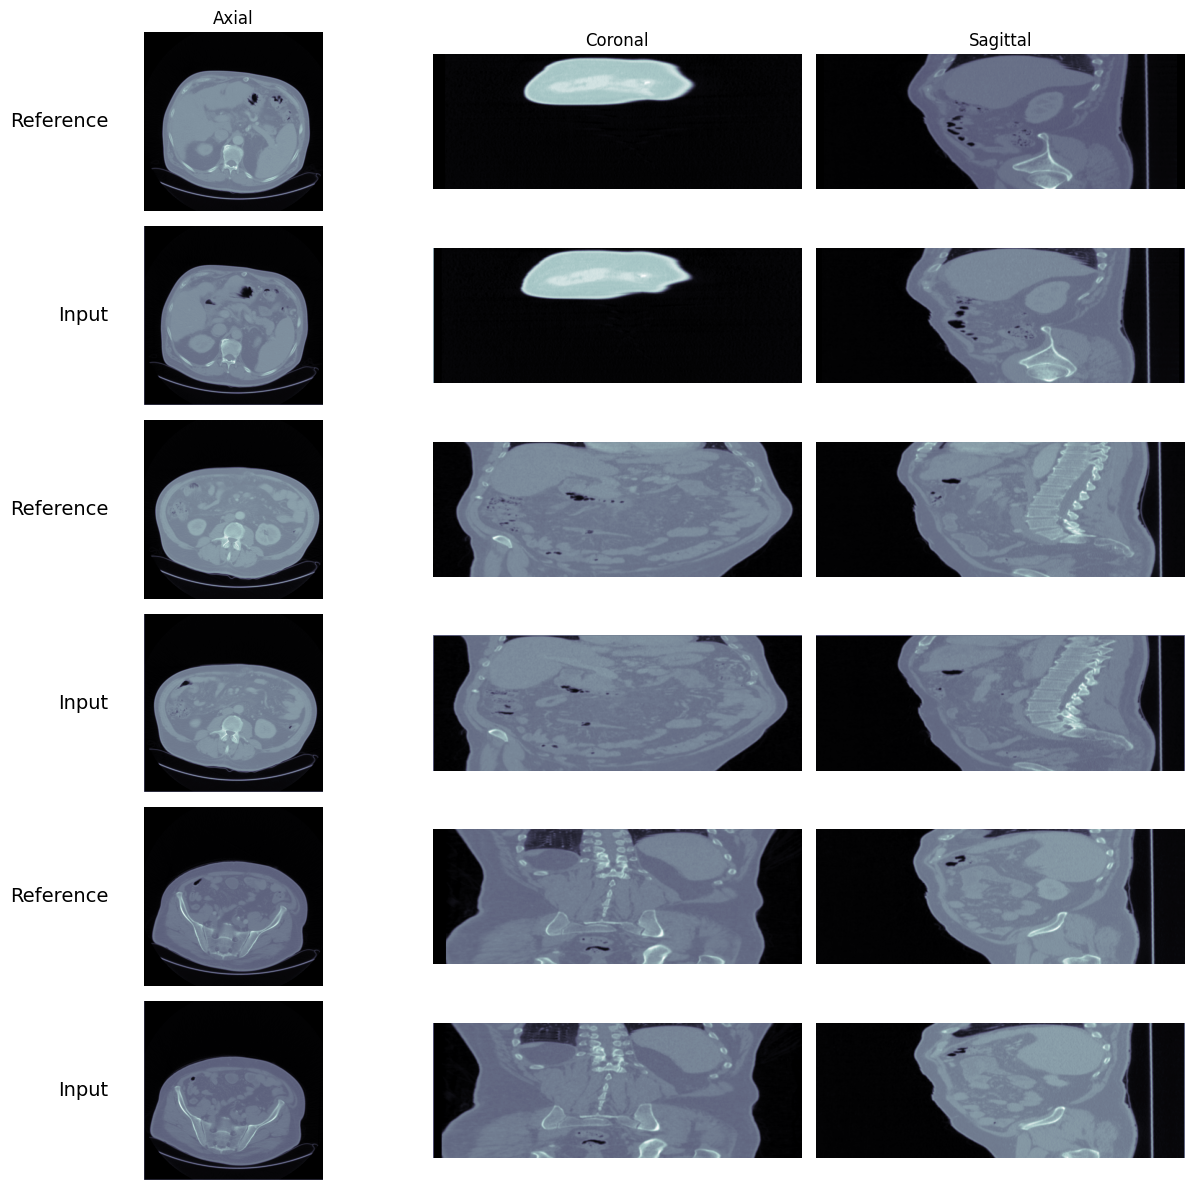

In [17]:
#Ref vs Transformed
plot_coregistration_views(pixelarray_ref, final_transform )

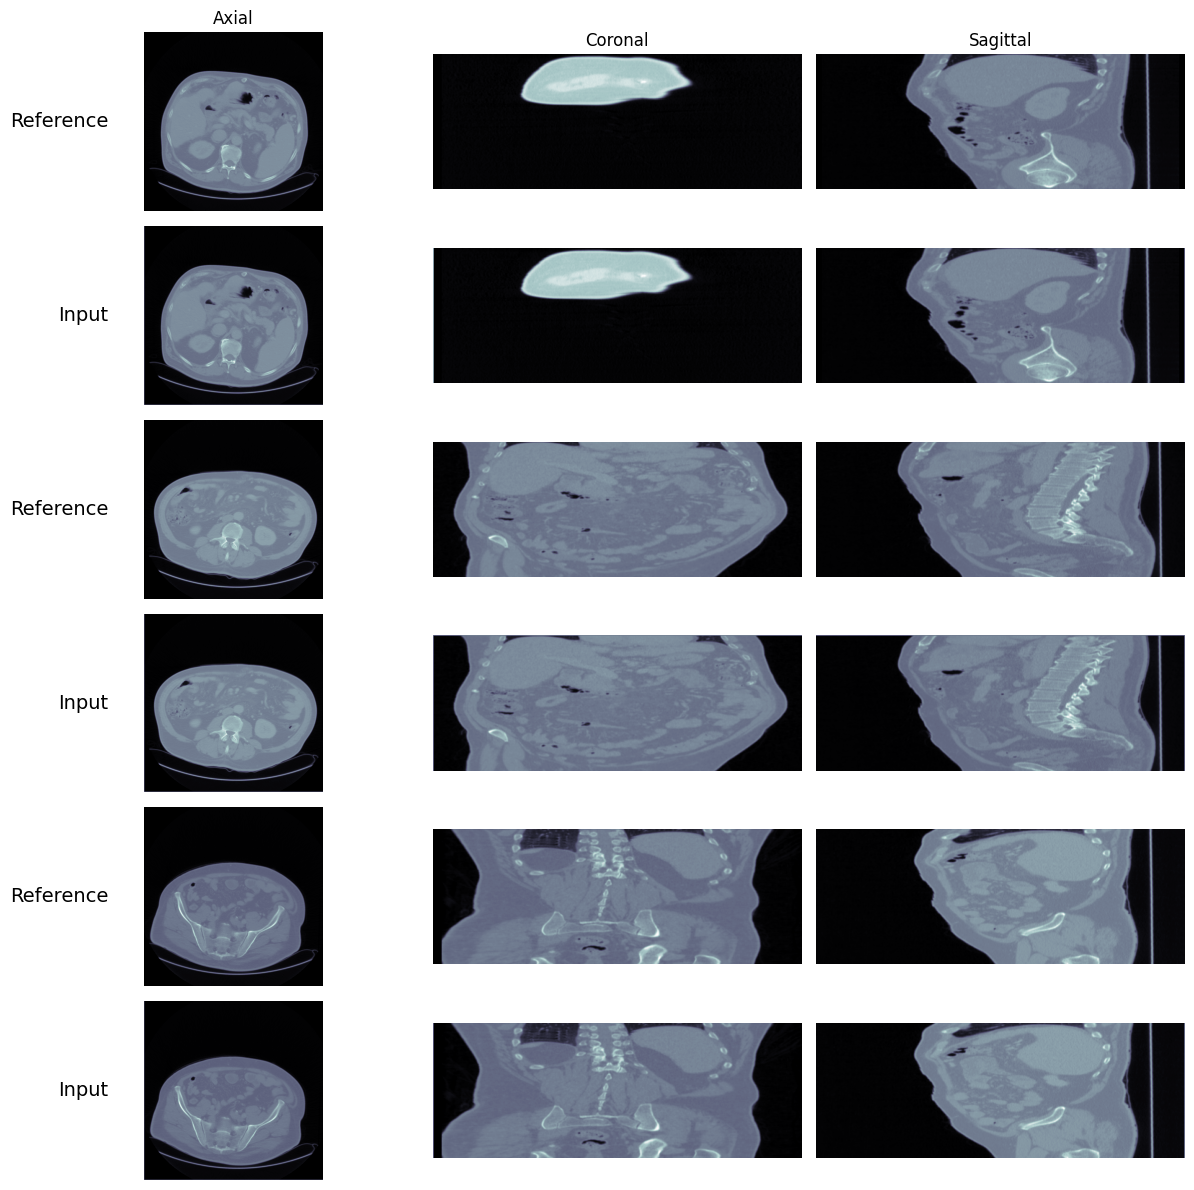

In [18]:
#Ref vs Transformed
plot_coregistration_views(pixelarray_input, final_transform )


Load the liver mask, apply the transformation and overlay to see the results

In [19]:
from task1_animation import create_seg_mask
import pydicom
from utils import maximum_intensity_projection

#Load Liver MAsk
liver_path="RadCTTACEomics_1193-20250418T131346Z-001/RadCTTACEomics_1193/10_AP_Ax2.50mm_ManualROI_Liver.dcm"

dcm_liver = pydicom.dcmread(liver_path)
mask_liver_original = create_seg_mask(dcm_liver, dcms_ref)
mask_liver_projected=apply_transform(mask_liver_original,final_params)
mask_liver_projected[mask_liver_projected>0]=1


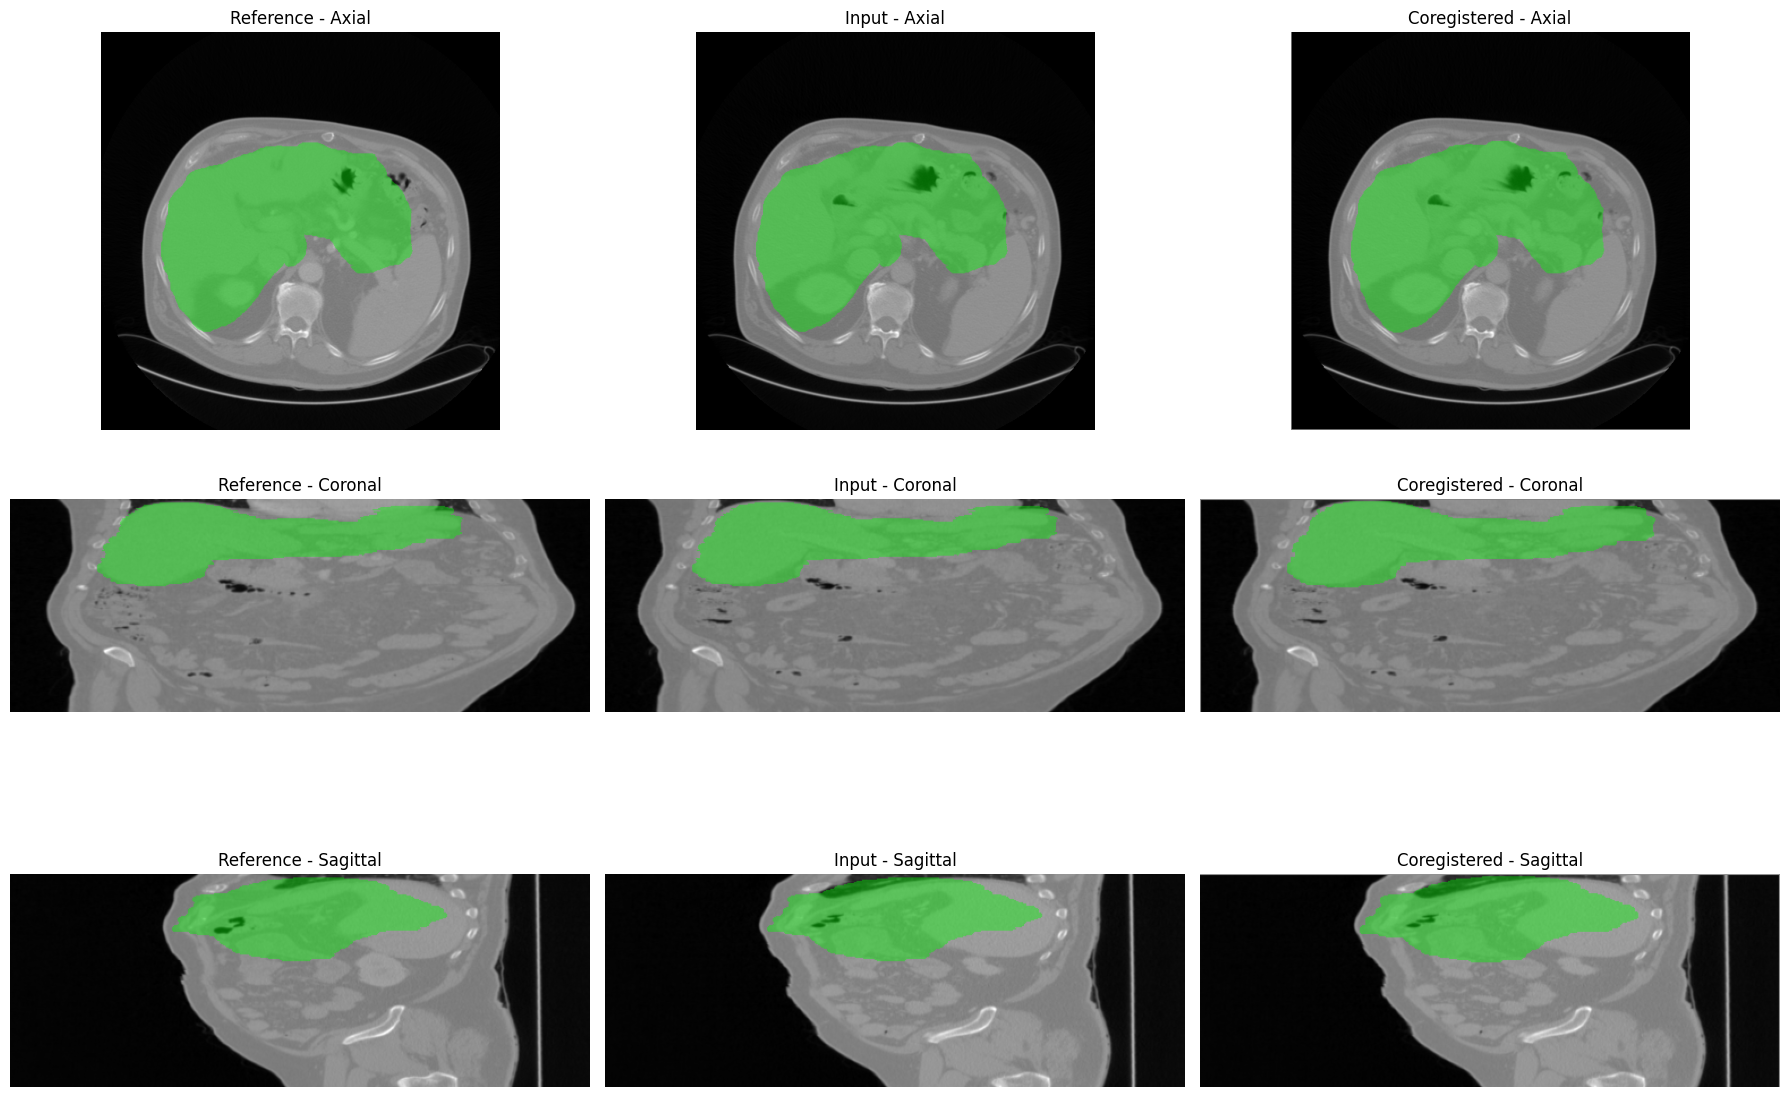

In [20]:
# Define slice indices
depth, height, width = pixelarray_ref.shape
axial_slice = depth // 4
coronal_slice = height // 2
sagittal_slice = 3 * width // 4

# Extract image slices (fixed views)
slices_ref = [
    pixelarray_ref[axial_slice, :, :],         # Axial
    pixelarray_ref[:, coronal_slice, :],       # Coronal
    pixelarray_ref[:, :, sagittal_slice]       # Sagittal
]

slices_input = [
    pixelarray_input[axial_slice, :, :],
    pixelarray_input[:, coronal_slice, :],
    pixelarray_input[:, :, sagittal_slice]
]

slices_coreg = [
    final_transform[axial_slice, :, :],
    final_transform[:, coronal_slice, :],
    final_transform[:, :, sagittal_slice]
]

# Compute liver overlays using MIP on correct axis
mask_ref_slices = [
    maximum_intensity_projection(mask_liver_original, axis=0),  # axial
    maximum_intensity_projection(mask_liver_original, axis=1),  # coronal
    maximum_intensity_projection(mask_liver_original, axis=2)   # sagittal
]

mask_proj_slices = [
    maximum_intensity_projection(mask_liver_projected, axis=0),
    maximum_intensity_projection(mask_liver_projected, axis=1),
    maximum_intensity_projection(mask_liver_projected, axis=2)
]
def overlay_liver_mask(image, mask, alpha=0.4):
    """
    Overlay a semi-transparent green mask on top of a grayscale image.
    
    Parameters:
        image (ndarray): 2D image array.
        mask (ndarray): 2D binary mask (same shape as image).
        alpha (float): Transparency level of the overlay (0 = fully transparent, 1 = fully opaque).
    
    Returns:
        ndarray: RGB image with green overlay where mask == 1.
    """
    # Normalize image to [0, 1]
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Convert to RGB
    rgb_image = np.stack([image_normalized]*3, axis=-1)
    
    # Create green layer
    green_overlay = np.zeros_like(rgb_image)
    green_overlay[..., 1] = 1.0  # full green

    # Alpha blend the green overlay where mask == 1
    rgb_image[mask == 1] = (
        (1 - alpha) * rgb_image[mask == 1] +
        alpha * green_overlay[mask == 1]
    )

    return rgb_image
# Overlay images
ref_overlay = [overlay_liver_mask(img, mask) for img, mask in zip(slices_ref, mask_ref_slices)]
input_overlay = [overlay_liver_mask(img, mask) for img, mask in zip(slices_input, mask_ref_slices)]
coreg_overlay = [overlay_liver_mask(img, mask) for img, mask in zip(slices_coreg, mask_proj_slices)]

# Plot
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
titles = ['Axial', 'Coronal', 'Sagittal']

for row in range(3):
    axes[row][0].imshow(ref_overlay[row])
    axes[row][0].set_title(f'Reference - {titles[row]}')
    axes[row][0].axis('off')

    axes[row][1].imshow(input_overlay[row])
    axes[row][1].set_title(f'Input - {titles[row]}')
    axes[row][1].axis('off')

    axes[row][2].imshow(coreg_overlay[row])
    axes[row][2].set_title(f'Coregistered - {titles[row]}')
    axes[row][2].axis('off')

plt.tight_layout()
plt.show()


From the figure above, each **row** corresponds to a different anatomical view: **Axial**, **Coronal**, and **Sagittal**. Each **column** represents a different stage of the registration process:

- **Left column**: Reference DICOM image with the original liver mask overlay.
- **Middle column**: Input image with the original (non-transformed) liver mask.
- **Right column**: Coregistered input image and liver mask after applying the estimated transformation parameters.

At a glance, the differences might seem subtle, but focusing on the **Axial view (top row)** reveals visible improvements in alignment—particularly in the liver contours and organ positioning. This suggests that the coregistration process has helped to better align the anatomical structures across volumes.
